
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states,  actions, targetQs, # model input data 
               action_size, hidden_size): # model init
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    Rs = tf.sigmoid(Qs)
    
    # Bellman equations is Qs = Rs + (0.99 * nextQs)
    #Qs = Rs + (gamma * nextQs)
    #Qs - Rs = gamma * nextQs
    # In this definition/description/explanation: targetQs = gamma * nextQs
    Qs_Rs = Qs - Rs
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs_Rs - targetQs))

    return actions_logits, q_loss, Rs

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [10]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.Rs = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [16]:
train_episodes = 2500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [17]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [18]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
meanRs_list, stdRs_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        meanRs, stdRs = 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training meanRs: {:.4f}'.format(np.mean(Rs)),
                      'Training stdRs: {:.4f}'.format(np.std(Rs)),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                meanRs_list.append((ep, np.mean(Rs)))
                stdRs_list.append((ep, np.std(Rs)))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1) # boolean

            # Calculating targetQs = Rs + (gamma * nextQs)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - episode_ends.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            #nextQs = next_actions_logits * next_actions_mask
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Bellman equation: Qs = Rs + (gamma * nextQs)
            #targetQs = rewards + (gamma * nextQs)
            targetQs = gamma * nextQs

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            Rs, q_loss, _ = sess.run([model.Rs, model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 85.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 16.9233 Explore P: 0.9916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 34.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 37.0243 Explore P: 0.9883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 22.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 82.6780 Explore P: 0.9861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 37.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Tra

-------------------------------------------------------------------------------
Episode: 30 Total reward: 12.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 628.2637 Explore P: 0.9193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 25.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 1023.0853 Explore P: 0.9171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 19.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 196.1852 Explore P: 0.9153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 17.0 Training meanRs: 1.0000 Training stdRs: 0.

-------------------------------------------------------------------------------
Episode: 59 Total reward: 40.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 17833.1602 Explore P: 0.8641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 60 Total reward: 20.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 14342.0938 Explore P: 0.8624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 28.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 23953.8574 Explore P: 0.8600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 31.0 Training meanRs: 1.0000 Training stdR

-------------------------------------------------------------------------------
Episode: 88 Total reward: 42.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 465769.5938 Explore P: 0.7849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 89 Total reward: 19.0 Training meanRs: 0.9925 Training stdRs: 0.0608 Training q_loss: 733327.9375 Explore P: 0.7834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 90 Total reward: 50.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 608582.8750 Explore P: 0.7795
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 22.0 Training meanRs: 0.9925 Training s

-------------------------------------------------------------------------------
Episode: 118 Total reward: 74.0 Training meanRs: 1.0000 Training stdRs: 0.0000 Training q_loss: 16194312.0000 Explore P: 0.6918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 119 Total reward: 44.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 59149956.0000 Explore P: 0.6888
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 120 Total reward: 37.0 Training meanRs: 0.9900 Training stdRs: 0.0700 Training q_loss: 50122692.0000 Explore P: 0.6863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 12.0 Training meanRs: 0.9975 

-------------------------------------------------------------------------------
Episode: 147 Total reward: 170.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 339708960.0000 Explore P: 0.5832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 95.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 415777792.0000 Explore P: 0.5778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 16.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 501419456.0000 Explore P: 0.5769
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 23.0 Training meanRs: 0.9

-------------------------------------------------------------------------------
Episode: 176 Total reward: 151.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 5732582912.0000 Explore P: 0.4131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 199.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 3845541376.0000 Explore P: 0.4052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 199.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 4786875392.0000 Explore P: 0.3974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 199.0 Training meanR

-------------------------------------------------------------------------------
Episode: 205 Total reward: 199.0 Training meanRs: 0.9950 Training stdRs: 0.0497 Training q_loss: 700658432.0000 Explore P: 0.2364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 199.0 Training meanRs: 0.9975 Training stdRs: 0.0353 Training q_loss: 2466762496.0000 Explore P: 0.2319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Training meanRs: 0.9875 Training stdRs: 0.0781 Training q_loss: 871857856.0000 Explore P: 0.2275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Training meanRs:

-------------------------------------------------------------------------------
Episode: 234 Total reward: 199.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 63570968.0000 Explore P: 0.1372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 199.0 Training meanRs: 0.9825 Training stdRs: 0.0919 Training q_loss: 434403296.0000 Explore P: 0.1347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 163.0 Training meanRs: 0.9775 Training stdRs: 0.1037 Training q_loss: 456854720.0000 Explore P: 0.1327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 237 Total reward: 199.0 Training meanRs: 0

-------------------------------------------------------------------------------
Episode: 263 Total reward: 199.0 Training meanRs: 0.9800 Training stdRs: 0.0980 Training q_loss: 5709320192.0000 Explore P: 0.0896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 264 Total reward: 199.0 Training meanRs: 0.9850 Training stdRs: 0.0853 Training q_loss: 1487939712.0000 Explore P: 0.0881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 265 Total reward: 199.0 Training meanRs: 0.9700 Training stdRs: 0.1187 Training q_loss: 2579857664.0000 Explore P: 0.0865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 199.0 Training meanR

-------------------------------------------------------------------------------
Episode: 292 Total reward: 199.0 Training meanRs: 0.8375 Training stdRs: 0.2342 Training q_loss: 13897263104.0000 Explore P: 0.0551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 183.0 Training meanRs: 0.8850 Training stdRs: 0.2104 Training q_loss: 9390507008.0000 Explore P: 0.0543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 294 Total reward: 160.0 Training meanRs: 0.8300 Training stdRs: 0.2369 Training q_loss: 14602648576.0000 Explore P: 0.0536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 181.0 Training mea

-------------------------------------------------------------------------------
Episode: 321 Total reward: 114.0 Training meanRs: 0.8400 Training stdRs: 0.2332 Training q_loss: 37992103936.0000 Explore P: 0.0373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 322 Total reward: 124.0 Training meanRs: 0.8700 Training stdRs: 0.2193 Training q_loss: 36988092416.0000 Explore P: 0.0370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 104.0 Training meanRs: 0.8075 Training stdRs: 0.2433 Training q_loss: 44063281152.0000 Explore P: 0.0367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 128.0 Training me

-------------------------------------------------------------------------------
Episode: 350 Total reward: 199.0 Training meanRs: 0.9400 Training stdRs: 0.1625 Training q_loss: 35783983104.0000 Explore P: 0.0280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 199.0 Training meanRs: 0.9025 Training stdRs: 0.1981 Training q_loss: 67499839488.0000 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 352 Total reward: 199.0 Training meanRs: 0.9100 Training stdRs: 0.1921 Training q_loss: 34104889344.0000 Explore P: 0.0273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 353 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 379 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 62596583424.0000 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 58729644032.0000 Explore P: 0.0201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 44276867072.0000 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 382 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 408 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 49249062912.0000 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 41013342208.0000 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 182.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 47916417024.0000 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 188.0 Training me

-------------------------------------------------------------------------------
Episode: 437 Total reward: 179.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 49084477440.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 167.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 58205163520.0000 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 49805373440.0000 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 466 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 45783330816.0000 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 160.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 41995476992.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 46779392000.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 165.0 Training me

-------------------------------------------------------------------------------
Episode: 495 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 65355108352.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 175.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 47997075456.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 497 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 49528958976.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 524 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 41293668352.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 75151433728.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 526 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 48398520320.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 527 Total reward: 180.0 Training me

-------------------------------------------------------------------------------
Episode: 553 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 55672643584.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 172.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 69299625984.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 32508112896.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 582 Total reward: 196.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 30326996992.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 31671977984.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 190.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 35971612672.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 611 Total reward: 164.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 25264007168.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 612 Total reward: 197.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 52150276096.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 196.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 32632721408.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 640 Total reward: 166.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 31121520640.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 28000090112.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 33513162752.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 643 Total reward: 193.0 Training me

-------------------------------------------------------------------------------
Episode: 669 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 47698956288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 175.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 40750411776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 45623975936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 698 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 39125606400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 169.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 39007911936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 172.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 48586960896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 727 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 29969006592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 41017610240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 729 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 44241403904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 730 Total reward: 172.0 Training me

-------------------------------------------------------------------------------
Episode: 756 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 27920584704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 757 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 28707551232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 758 Total reward: 174.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 51636076544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 759 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 785 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 36272185344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19089426432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 162.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 34549977088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 814 Total reward: 184.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24794128384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 815 Total reward: 177.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24408061952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 816 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 31130796032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 843 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19219423232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 844 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23588018176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 845 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19691282432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 846 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 872 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17452333056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18535354368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 874 Total reward: 197.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19314178048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 875 Total reward: 167.0 Training me

-------------------------------------------------------------------------------
Episode: 901 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21984849920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18265868288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22127613952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 930 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18133274624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 186.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21417746432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19438415872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 959 Total reward: 182.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22699501568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 960 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20044761088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 961 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19124127744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 988 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17651720192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17638612992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 990 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18801985536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 199.0 Training me

-------------------------------------------------------------------------------
Episode: 1017 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23312787456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1018 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19328593920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1019 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21238534144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1020 Total reward: 169.0 Trainin

-------------------------------------------------------------------------------
Episode: 1045 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16128451584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1046 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19580411904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1047 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21350955008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1048 Total reward: 173.0 Trainin

-------------------------------------------------------------------------------
Episode: 1073 Total reward: 181.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18734395392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1074 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21516630016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1075 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19135731712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1076 Total reward: 162.0 Trainin

-------------------------------------------------------------------------------
Episode: 1101 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20566237184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16386994176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20385839104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1129 Total reward: 170.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15659035648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1130 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15763222528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1131 Total reward: 188.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18625908736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1157 Total reward: 167.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20942981120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1158 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15375758336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1159 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21798686720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1160 Total reward: 194.0 Trainin

-------------------------------------------------------------------------------
Episode: 1185 Total reward: 160.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17048552448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1186 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17838809088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1187 Total reward: 179.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16511358976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1188 Total reward: 183.0 Trainin

-------------------------------------------------------------------------------
Episode: 1213 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21709172736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19078715392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1215 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18497714176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1216 Total reward: 169.0 Trainin

-------------------------------------------------------------------------------
Episode: 1241 Total reward: 176.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21222653952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1242 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16201125888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1243 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21508773888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 193.0 Trainin

-------------------------------------------------------------------------------
Episode: 1269 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21929601024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1270 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17336612864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1271 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22510604288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1272 Total reward: 196.0 Trainin

-------------------------------------------------------------------------------
Episode: 1297 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19409397760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20955119616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19775340544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1300 Total reward: 165.0 Trainin

-------------------------------------------------------------------------------
Episode: 1325 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18931245056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20777521152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 180.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21091135488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1328 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1353 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16593206272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1354 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15032978432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1355 Total reward: 179.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20551860224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1356 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1381 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19098527744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1382 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19171530752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1383 Total reward: 194.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16585338880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1384 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1409 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18112264192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1410 Total reward: 178.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17075913728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1411 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18554707968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1412 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1437 Total reward: 195.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21726625792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1438 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20701810688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1439 Total reward: 173.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22569605120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1440 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1465 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18328268800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1466 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19984652288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1467 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 14754760704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1468 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1493 Total reward: 174.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16839445504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1494 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24429314048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1495 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18571546624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1496 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1521 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18445082624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20730687488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 169.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20203214848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1524 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1549 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22072084480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1550 Total reward: 192.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18883774464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1551 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16392569856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1552 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1577 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19592847360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1578 Total reward: 163.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19414382592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19731365888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1605 Total reward: 173.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19697567744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1606 Total reward: 188.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21790765056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1607 Total reward: 177.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18890088448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1608 Total reward: 168.0 Trainin

-------------------------------------------------------------------------------
Episode: 1633 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24110080000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1634 Total reward: 164.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17006577664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1635 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22629072896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1636 Total reward: 184.0 Trainin

-------------------------------------------------------------------------------
Episode: 1661 Total reward: 189.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17625024512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1662 Total reward: 166.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18978381824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1663 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24896636928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1664 Total reward: 198.0 Trainin

-------------------------------------------------------------------------------
Episode: 1689 Total reward: 165.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17449390080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1690 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24123187200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1691 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22869782528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1692 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1717 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20823662592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1718 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17771227136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1719 Total reward: 188.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19494045696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1720 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 1745 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23085998080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1746 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18987229184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 198.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20946561024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 172.0 Trainin

-------------------------------------------------------------------------------
Episode: 1773 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20622688256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1774 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21740591104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1775 Total reward: 190.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19652052992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 173.0 Trainin

-------------------------------------------------------------------------------
Episode: 1801 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19538108416.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1802 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18385651712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1803 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 25055105024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1804 Total reward: 179.0 Trainin

-------------------------------------------------------------------------------
Episode: 1829 Total reward: 186.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19383955456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1830 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16999532544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1831 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22710755328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1832 Total reward: 191.0 Trainin

-------------------------------------------------------------------------------
Episode: 1857 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18481872896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1858 Total reward: 183.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18984259584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1859 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20533798912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1860 Total reward: 156.0 Trainin

-------------------------------------------------------------------------------
Episode: 1885 Total reward: 186.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16143383552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1886 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17217720320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1887 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21505816576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1888 Total reward: 176.0 Trainin

-------------------------------------------------------------------------------
Episode: 1913 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23234025472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23442722816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22400872448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1916 Total reward: 183.0 Trainin

-------------------------------------------------------------------------------
Episode: 1941 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16863163392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1942 Total reward: 182.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23576451072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18275670016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 173.0 Trainin

-------------------------------------------------------------------------------
Episode: 1969 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17961441280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1970 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18969667584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1971 Total reward: 170.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18360694784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1972 Total reward: 191.0 Trainin

-------------------------------------------------------------------------------
Episode: 1997 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20777437184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1998 Total reward: 172.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20842592256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1999 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15961729024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2000 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2025 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22193164288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2026 Total reward: 173.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17923545088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2027 Total reward: 186.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17625473024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2028 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2053 Total reward: 177.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19889856512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2054 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21991763968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2055 Total reward: 181.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21027928064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2056 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2081 Total reward: 185.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 15921855488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2082 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17814310912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2083 Total reward: 179.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20617902080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2084 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2109 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18635888640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2110 Total reward: 156.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18174191616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2111 Total reward: 198.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 24943968256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2112 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2137 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17648195584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2138 Total reward: 187.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22442016768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2139 Total reward: 161.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22193451008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2140 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2165 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19654948864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2166 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18360367104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2167 Total reward: 182.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21541765120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2168 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2193 Total reward: 173.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23272628224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2194 Total reward: 171.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17213435904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2195 Total reward: 196.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21303513088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2196 Total reward: 192.0 Trainin

-------------------------------------------------------------------------------
Episode: 2221 Total reward: 178.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21417902080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2222 Total reward: 171.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19698286592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2223 Total reward: 190.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20845522944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2224 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2249 Total reward: 190.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22035128320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2250 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18770552832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2251 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18639882240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2252 Total reward: 158.0 Trainin

-------------------------------------------------------------------------------
Episode: 2277 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19598899200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2278 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 20469530624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2279 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17091408896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2280 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2305 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22548809728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2306 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17380356096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2307 Total reward: 187.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19038654464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2308 Total reward: 194.0 Trainin

-------------------------------------------------------------------------------
Episode: 2333 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17523763200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2334 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18230376448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2335 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 23053287424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2336 Total reward: 176.0 Trainin

-------------------------------------------------------------------------------
Episode: 2361 Total reward: 190.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22029789184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2362 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17863172096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2363 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 22209370112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2364 Total reward: 183.0 Trainin

-------------------------------------------------------------------------------
Episode: 2389 Total reward: 187.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18111490048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2390 Total reward: 177.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18590169088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2391 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17307125760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2392 Total reward: 171.0 Trainin

-------------------------------------------------------------------------------
Episode: 2417 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 16946293760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2418 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17964374016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2419 Total reward: 191.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 18372055040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2445 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 17675145216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2446 Total reward: 168.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19443302400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2447 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19241168896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2448 Total reward: 199.0 Trainin

-------------------------------------------------------------------------------
Episode: 2473 Total reward: 158.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 19058950144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2474 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21842272256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2475 Total reward: 199.0 Training meanRs: 0.5000 Training stdRs: 0.0000 Training q_loss: 21524232192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2476 Total reward: 170.0 Trainin

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

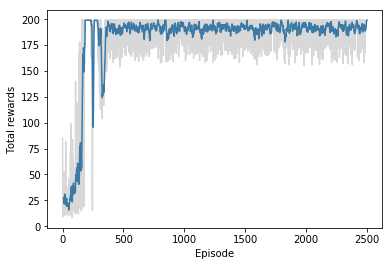

In [26]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

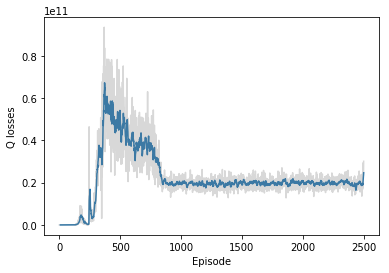

In [27]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'Q losses')

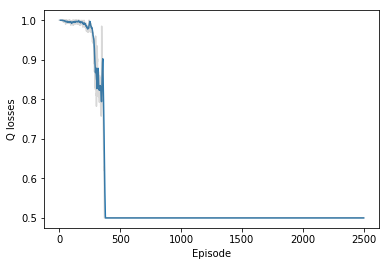

In [30]:
eps, arr = np.array(meanRs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'Q losses')

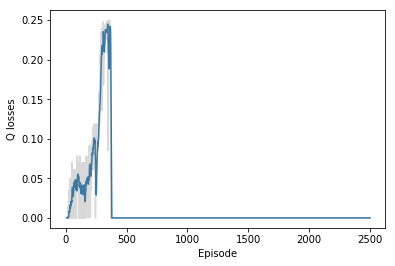

In [31]:
eps, arr = np.array(stdRs_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.